In [822]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import GridSearchCV,RandomizedSearchCV,StratifiedKFold
from sklearn.preprocessing import Binarizer

from sklearn.linear_model import LogisticRegression
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

from sklearn.metrics import accuracy_score, f1_score, recall_score,precision_score,roc_auc_score
from sklearn.metrics import precision_recall_curve,roc_curve,confusion_matrix , auc

from sklearn.inspection import permutation_importance
import eli5
from eli5.sklearn import PermutationImportance

from sklearn.pipeline import Pipeline,make_pipeline

In [445]:
def model_basic(x_train, y_train, x_test, y_test): 
    models = [
        LogisticRegression(),
        LinearDiscriminantAnalysis(),
        GaussianNB(),
        RandomForestClassifier(),
        XGBClassifier()
    ]

    rdict={'model':[],'acc_train':[], 'auc_train':[], 'acc_test':[],'precision':[],'recall':[],'f1_score':[], 'AUC_test':[]}


    for clf in models:
        clf = clf.fit(x_train, y_train)
    #1열:Train
        y_hat = clf.predict(x_train)
        results_train  = (round(accuracy_score(y_train,y_hat),2),round(roc_auc_score(y_train,y_hat),2))
    #2열:Test
        y_hat = clf.predict(x_test)
        results = (round(accuracy_score(y_test,y_hat),2),
                        round(precision_score(y_test,y_hat),2),
                        round(recall_score(y_test,y_hat),2),
                        round(f1_score(y_test,y_hat),2),
                        round(roc_auc_score(y_test,y_hat),2))

        rdict['model'].append(clf); 
        rdict['acc_train'].append(results_train[0])
        rdict['auc_train'].append(results_train[1])
        
        rdict['acc_test'].append(results[0])
        rdict['precision'].append(results[1])
        rdict['recall'].append(results[2])
        rdict['f1_score'].append(results[3])
        rdict['AUC_test'].append(results[4])   

        confusion = confusion_matrix(y_test, y_hat)

        print(confusion)

    rdf_final = pd.DataFrame(data=rdict)
    return rdf_final

In [446]:
def eval(test,pred):
    acc = accuracy_score(test,pred)
    f1 = f1_score(test,pred)
    precision = precision_score(test,pred)
    recall = recall_score(test,pred)
    print('##############\n',confusion_matrix(test,pred),
    "############\n",f'acc_score: {acc}\n f1_score: {f1} \n precision: {precision} \n recall: {recall}')

## 임계값 =[] 리스트생성 후 for 구문
def get_eval_by_threshold(y_test , pred_proba_c1, thresholds=[0.5,0.52,0.54,0.56,0.58,0.6,0.62]):
    # thresholds list객체내의 값을 차례로 iteration하면서 Evaluation 수행.
    for custom_threshold in thresholds:
        binarizer = Binarizer(threshold=custom_threshold).fit(pred_proba_c1) 
        custom_predict = binarizer.transform(pred_proba_c1)
        print('임곗값:',custom_threshold)
        eval(y_test , custom_predict)


def precision_recall_curve_plot(y_test , pred_proba_c1):
    # threshold ndarray와 이 threshold에 따른 정밀도, 재현율 ndarray 추출. 
    precisions, recalls, thresholds = precision_recall_curve( y_test, pred_proba_c1)
    
    # X축을 threshold값으로, Y축은 정밀도, 재현율 값으로 각각 Plot 수행. 정밀도는 점선으로 표시
    plt.figure(figsize=(8,6))
    threshold_boundary = thresholds.shape[0]
    plt.plot(thresholds, precisions[0:threshold_boundary], linestyle='--', label='precision')
    plt.plot(thresholds, recalls[0:threshold_boundary],label='recall')
    
    # threshold 값 X 축의 Scale을 0.1 단위로 변경
    start, end = plt.xlim()
    plt.xticks(np.round(np.arange(start, end, 0.1),2))
    
    # x축, y축 label과 legend, 그리고 grid 설정
    plt.xlabel('Threshold value'); plt.ylabel('Precision and Recall value')
    plt.legend(); plt.grid()
    plt.show()
    

## roc curve_plot    
def roc_curve_plot(y_test,pred_proba):
    fprs, tprs, thresholds = roc_curve(y_test,pred_proba) ## 입력시 1레이블 컬럼만 추출
    
    # Roc curve를 plot 곡선으로 기름
    plt.plot(fprs,tprs,label='ROC')
    ## 가운데 대각선 직선을 그림
    plt.plot([0,1],[0,1],"k--",label="ramdom")
    
    ## fpr x축을 scale을 0.1단위로 변경 x,y축 명 설정
    start,end = plt.xlim()
    plt.xticks(np.round(np.arange(start,end,0.1),2))
    plt.xlim(0,1)
    plt.ylim(0,1)
    plt.xlabel('FPR(1-sensitivity)')
    plt.ylabel('TPR(recall)')
    plt.legend()
    plt.show()

In [447]:
def plot_pr_auc_curve(y_true, y_pred_proba):
    # Calculate precision, recall and threshold values
    precision, recall, thresholds = precision_recall_curve(y_true, y_pred_proba)
    # Calculate PR-AUC score
    pr_auc = auc(recall, precision)
    # Plot the PR-AUC curve
    plt.plot(recall, precision, label=f'PR-AUC = {pr_auc:.2f}')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('PR-AUC Curve')
    plt.legend()
    plt.show()

def get_pr_auc_score(y_true, y_pred_proba):
    # Calculate precision, recall and threshold values
    precision, recall, thresholds = precision_recall_curve(y_true, y_pred_proba)
    # Calculate PR-AUC score
    pr_auc = auc(recall, precision)
    return pr_auc

In [825]:
## 스케일링 처리 안한 데이터 
train = pd.read_csv("./datasets/통계검증완료/코스닥스케일X_train.csv", index_col=0)
test = pd.read_csv("./datasets/통계검증완료/코스닥스케일X_test.csv", index_col=0)

id_col = ['회사명', '거래소코드', '회계년도', '산업군','target_3']

최종_col_3 =  ['abs(영업현금흐름-당기순이익)/매출액','금융비용부담률','당기전기영업손익' ,'누적수익성비율', 'TMD','순운전자본비율']


train_x = train[최종_col_3]
train_y = train["target_3"]

test_x = test[최종_col_3]
test_y = test["target_3"]

In [ ]:
## 불균형 처리 안한 데이터 
train = pd.read_csv("./datasets/통계검증완료/코스닥_standard_train.csv", index_col=0)
test = pd.read_csv("./datasets/통계검증완료/코스닥_standard_test.csv", index_col=0)

id_col = ['회사명', '거래소코드', '회계년도', '산업군','target_3']


최종_col_3 =  ['abs(영업현금흐름-당기순이익)/매출액','금융비용부담률','당기전기영업손익' ,'누적수익성비율', 'TMD','순운전자본비율']

sc_train_x = train[최종_col_3]
sc_train_y = train["target_3"]

sc_test_x = test[최종_col_3]
sc_test_y = test["target_3"]

In [537]:
# # 불균형 처리한 후 데이터
# train = pd.read_csv('./datasets/불균형처리/boder_코스닥_standar_train.csv',index_col=0)
# train_x = train.drop(['target_3'],axis=1)
# train_y = train['target_3']

# test = pd.read_csv('./datasets/불균형처리/코스닥_standard_test.csv',index_col=0)
# test_x = test.drop(['회사명','거래소코드','회계년도','산업군','target_3'],axis=1)
# test_y = test['target_3']

## random과grid차이
- random은 넓은 범위에 하이퍼파라미터를 찾을때 효율적 랜덤한 조합으로 학습시키기때문 - 그러나 어떤조합은 적합시키지 않을수있음 그러므로 반복횟수를 적절하게 조절하는것이필요
- grid는 모든경우에 수를 적합시킴 그러므로 조합의 수가 많아진다면 시간이 오래걸리기때문에 오히려 random으로했을때 시간적으로 효율적일 수 있음
------------------------------------

## GLM
---


In [715]:
import statsmodels.formula.api as smf
import statsmodels.api as sm
formula = 'target_3 ~ 금융비용부담률+당기전기영업손익 +누적수익성비율+ TMD+순운전자본비율'
model = smf.glm(formula,data=train,family=sm.families.Binomial()).fit()

model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:               target_3   No. Observations:                 4988
Model:                            GLM   Df Residuals:                     4982
Model Family:                Binomial   Df Model:                            5
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -402.50
Date:                Tue, 25 Apr 2023   Deviance:                       805.00
Time:                        17:22:34   Pearson chi2:                 6.38e+03
No. Iterations:                     8   Pseudo R-squ. (CS):             0.1212
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -4.2971      0.182    -23.667      0.000      -4.653      -3.941
금융비용부담률        0.0601      0.018      3.348      0.001       0.025       0.095
당기전기영업손익    -9.93e-05   1.36e-05     -7.325      0.000      -0.000   -7.27e-05
누적수익성비율       -1.7803      0.167    -10.677      0.000      -2.107      -1.454
TMD            0.3605      0.060      5.978      0.000       0.242       0.479
순운전자본비율       -0.0151      0.005     -3.170      0.002      -0.024      -0.006
==============================================================================
"""

## LOGISTIC

In [699]:
c = train_y.value_counts(property)
c

0    0.966921
1    0.033079
Name: target_3, dtype: float64

In [826]:
lr=LogisticRegression(random_state=1,n_jobs=-1)
param = {
    'solver' :['lbfgs', 'liblinear','sag', 'saga'],
    'C': [0.01,0.1,0.5, 1,5,10],
    'penalty': ['l2'],
    'max_iter':[150,170],
    'class_weight':[None,'balanced',{0:1/c[0],1:1/c[1]}]
}
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=1)

grid_lr = GridSearchCV(lr,n_jobs=-1,scoring='f1',cv=cv,param_grid=param,refit=True)
grid_lr.fit(train_x,train_y)

scores_df = pd.DataFrame(grid_lr.cv_results_)
scores_df[scores_df['rank_test_score']==1]

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_C,param_class_weight,param_max_iter,param_penalty,param_solver,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
100,0.124846,0.013175,0.005983,0.001092,5,None,170,l2,lbfgs,"{'C': 5, 'class_weight': None, 'max_iter': 170...",0.434783,0.603774,0.56,0.434783,0.627451,0.532158,0.0824,1


In [883]:
print(grid_lr.best_params_)
pred = grid_lr.predict(test_x)
pred_prob = grid_lr.predict_proba(test_x)[:,1].reshape(-1,1)
eval(pred=pred,test=test_y)

{'C': 5, 'class_weight': None, 'max_iter': 170, 'penalty': 'l2', 'solver': 'lbfgs'}
##############
 [[2799   15]
 [  30   42]] ############
 acc_score: 0.9844074844074844
 f1_score: 0.6511627906976745 
 precision: 0.7368421052631579 
 recall: 0.5833333333333334


In [884]:
logit = LogisticRegression(C=5,max_iter=170,penalty='l2',solver='lbfgs',random_state=1)
logit.fit(train_x,train_y)
pd.DataFrame(data=logit.coef_,columns=logit.feature_names_in_)

,abs(영업현금흐름-당기순이익)/매출액,금융비용부담률,당기전기영업손익,누적수익성비율,TMD,순운전자본비율
0,1.081492,0.046924,-0.000089,-1.734684,0.398266,-0.015136


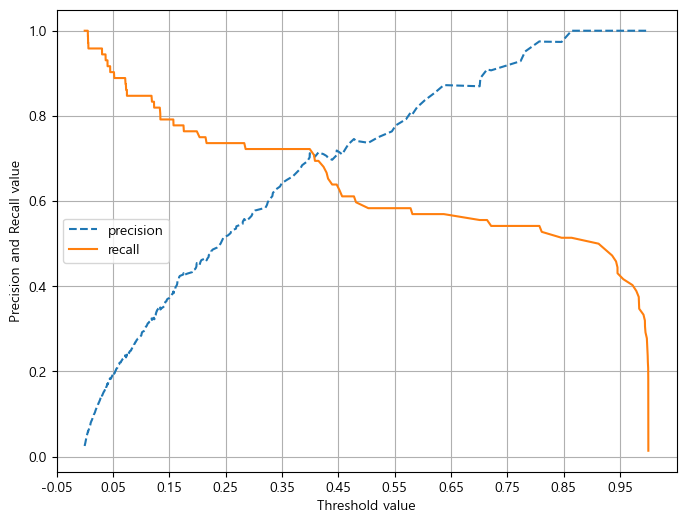

In [886]:
precision_recall_curve_plot(test_y,pred_prob)

In [887]:
get_eval_by_threshold(test_y,pred_prob,[0.40])

임곗값: 0.4
##############
 [[2793   21]
 [  21   51]] ############
 acc_score: 0.9854469854469855
 f1_score: 0.7083333333333334 
 precision: 0.7083333333333334 
 recall: 0.7083333333333334


Text(51.722222222222214, 0.5, 'Actual')

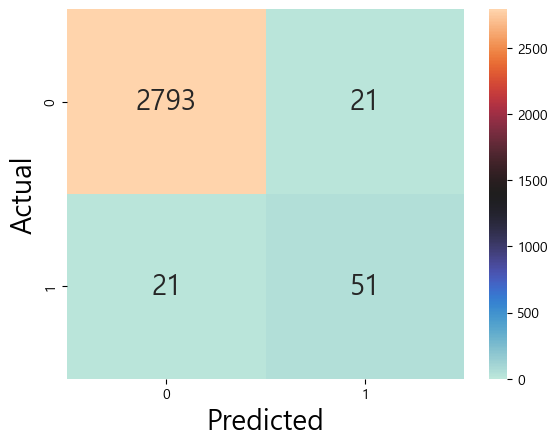

In [888]:
binarizer = Binarizer(threshold=0.40).fit(pred_prob) 
custom_rf = binarizer.transform(pred_prob)
cm = confusion_matrix(test_y, custom_rf)
sns.heatmap(cm, annot=True, annot_kws={"size": 20}, cmap="icefire", fmt='g',vmin=0)
plt.xlabel('Predicted', fontsize=20)
plt.ylabel('Actual', fontsize=20)

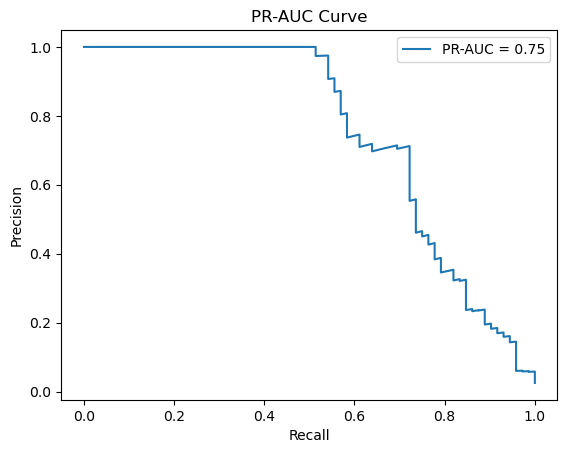

0.7507411379369516

In [733]:
plot_pr_auc_curve(test_y,pred_prob)
get_pr_auc_score(test_y,pred_prob)

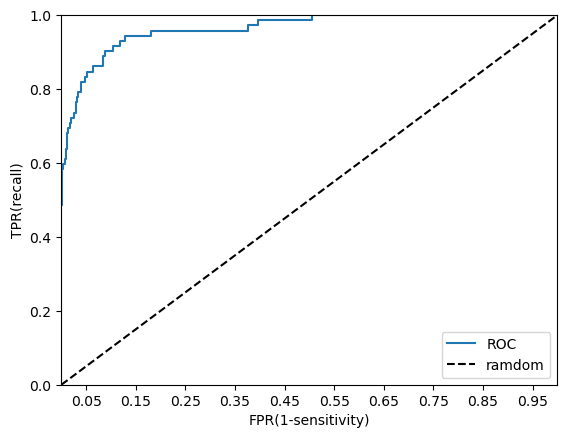

auc 값: 0.9643


In [721]:
## roc 커브 auc 값
roc_curve_plot(test_y,pred_prob)
auc_score = roc_auc_score(test_y,pred_prob)
print(f'auc 값: {np.round(auc_score,4)}')

## LDA

In [786]:
proi = sc_train_y.value_counts(property)

In [789]:
lda = LinearDiscriminantAnalysis()
param = {
    'solver': ['svd', 'lsqr', 'eigen'],
    'shrinkage': [None,'auto'],
    'priors': [[proi[0],proi[1]],None]
}

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=1)
grid_lda = GridSearchCV(lda, param_grid=param, scoring='accuracy', cv=cv, n_jobs=-1, refit=True)
grid_lda.fit(sc_train_x, sc_train_y)

scores_df = pd.DataFrame(grid_lda.cv_results_)
scores_df.loc[:, 'param_solver':'mean_test_score']


c:\Users\msi\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:378: FitFailedWarning: 
10 fits failed out of a total of 60.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
10 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\msi\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\msi\anaconda3\lib\site-packages\sklearn\discriminant_analysis.py", line 615, in fit
    raise NotImplementedError("shrinkage not supported with 'svd' solver.")
NotImplementedError: shrinkage not supported with 'svd' solver.

  warnings.warn(some_fits_failed_message, FitFailedWarning)
c:\Users\msi

,param_solver,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score
0,svd,"{'priors': [0.9669206094627105, 0.033079390537...",0.971944,0.976954,0.973948,0.971916,0.977934,0.974539
1,lsqr,"{'priors': [0.9669206094627105, 0.033079390537...",0.971944,0.976954,0.973948,0.971916,0.977934,0.974539
2,eigen,"{'priors': [0.9669206094627105, 0.033079390537...",0.971944,0.976954,0.973948,0.971916,0.977934,0.974539
3,svd,"{'priors': [0.9669206094627105, 0.033079390537...",NaN,NaN,NaN,NaN,NaN,NaN
4,lsqr,"{'priors': [0.9669206094627105, 0.033079390537...",0.970942,0.977956,0.977956,0.968907,0.979940,0.975140
5,eigen,"{'priors': [0.9669206094627105, 0.033079390537...",0.970942,0.977956,0.977956,0.968907,0.979940,0.975140
6,svd,"{'priors': None, 'shrinkage': None, 'solver': ...",0.971944,0.976954,0.973948,0.971916,0.977934,0.974539
7,lsqr,"{'priors': None, 'shrinkage': None, 'solver': ...",0.971944,0.976954,0.973948,0.971916,0.977934,0.974539
8,eigen,"{'priors': None, 'shrinkage': None, 'solver': ...",0.971944,0.976954,0.973948,0.971916,0.977934,0.974539
9,svd,"{'priors': None, 'shrinkage': 'auto', 'solver'...",NaN,NaN,NaN,NaN,NaN,NaN


In [959]:
print(grid_lda.best_params_)
pred = grid_lda.predict(sc_test_x)
pred_prob = grid_lda.predict_proba(sc_test_x)[:,1].reshape(-1,1)
eval(pred=pred,test=sc_test_y)

{'priors': [0.9669206094627105, 0.0330793905372895], 'shrinkage': 'auto', 'solver': 'lsqr'}
##############
 [[2760   54]
 [  22   50]] ############
 acc_score: 0.9736659736659736
 f1_score: 0.5681818181818181 
 precision: 0.4807692307692308 
 recall: 0.6944444444444444


In [960]:
get_eval_by_threshold(sc_test_y,pred_prob,[0.95])

임곗값: 0.95
##############
 [[2788   26]
 [  28   44]] ############
 acc_score: 0.9812889812889813
 f1_score: 0.619718309859155 
 precision: 0.6285714285714286 
 recall: 0.6111111111111112


Text(51.722222222222214, 0.5, 'Actual')

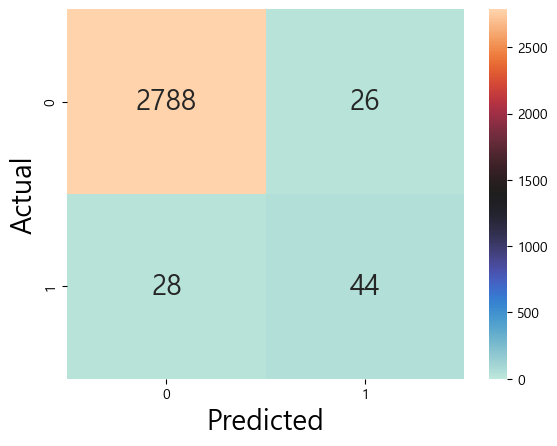

In [961]:
binarizer = Binarizer(threshold=0.95).fit(pred_prob) 
custom_rf = binarizer.transform(pred_prob)
cm = confusion_matrix(test_y, custom_rf)
sns.heatmap(cm, annot=True, annot_kws={"size": 20}, cmap="icefire", fmt='g',vmin=0)
plt.xlabel('Predicted', fontsize=20)
plt.ylabel('Actual', fontsize=20)

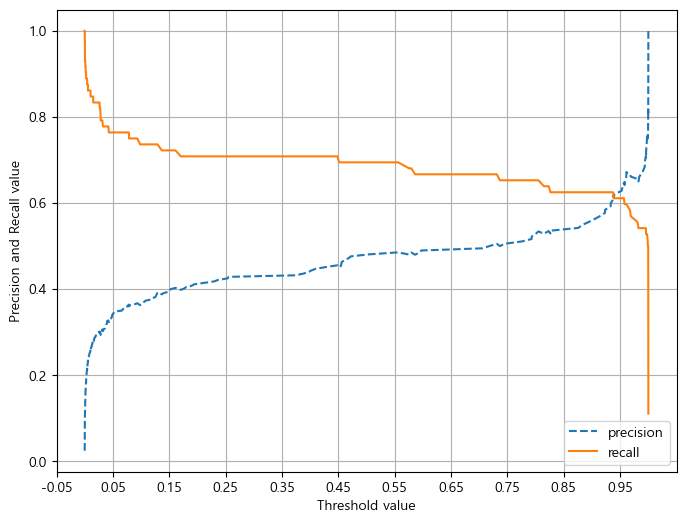

In [907]:
precision_recall_curve_plot(sc_test_y,pred_prob)

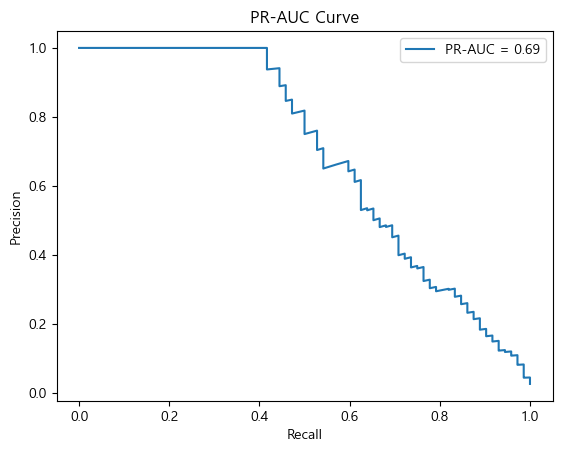

0.6853571687610298

In [908]:
plot_pr_auc_curve(sc_test_y,pred_prob)
get_pr_auc_score(sc_test_y,pred_prob)

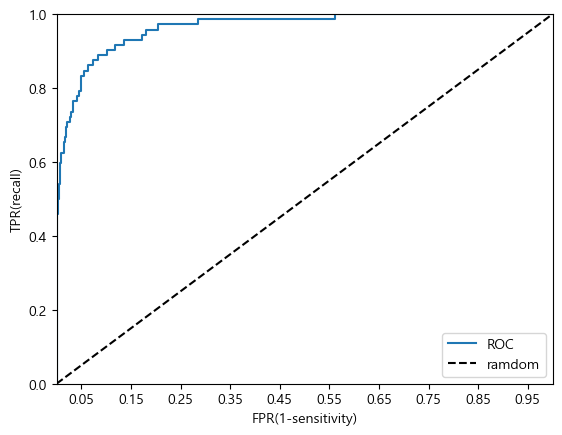

auc 값: 0.9643


In [909]:
## roc 커브 auc 값
roc_curve_plot(sc_test_y,pred_prob)
auc_score = roc_auc_score(sc_test_y,pred_prob)
print(f'auc 값: {np.round(auc_score,4)}')

## Gaussian_NB

In [910]:
a = sc_train_y.value_counts(property)

In [963]:
nb=GaussianNB(priors=[a[0],a[1]])

nb.fit(sc_train_x,sc_train_y)

pred = nb.predict(sc_test_x)
pred_prob = nb.predict_proba(sc_test_x)[:,1].reshape(-1,1)
eval(pred=pred,test=sc_test_y)

##############
 [[2678  136]
 [  18   54]] ############
 acc_score: 0.9466389466389467
 f1_score: 0.4122137404580153 
 precision: 0.28421052631578947 
 recall: 0.75


In [923]:
get_eval_by_threshold(sc_test_y,pred_prob,[0.9999999999999999])

임곗값: 0.9999999999999999
##############
 [[2787   27]
 [  32   40]] ############
 acc_score: 0.9795564795564795
 f1_score: 0.5755395683453237 
 precision: 0.5970149253731343 
 recall: 0.5555555555555556


Text(51.722222222222214, 0.5, 'Actual')

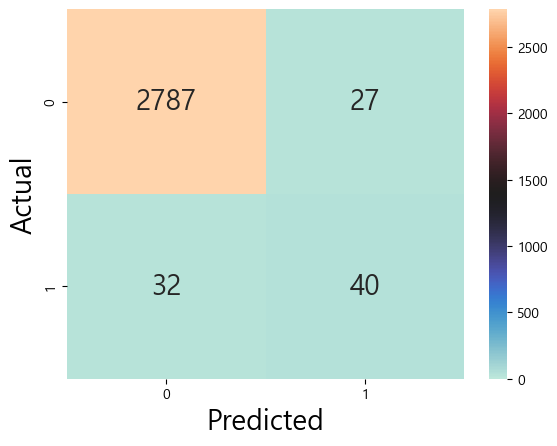

In [966]:
binarizer = Binarizer(threshold=0.9999999999999999).fit(pred_prob) 
custom_rf = binarizer.transform(pred_prob)
cm = confusion_matrix(test_y, custom_rf)
sns.heatmap(cm, annot=True, annot_kws={"size": 20}, cmap="icefire", fmt='g',vmin=0)
plt.xlabel('Predicted', fontsize=20)
plt.ylabel('Actual', fontsize=20)

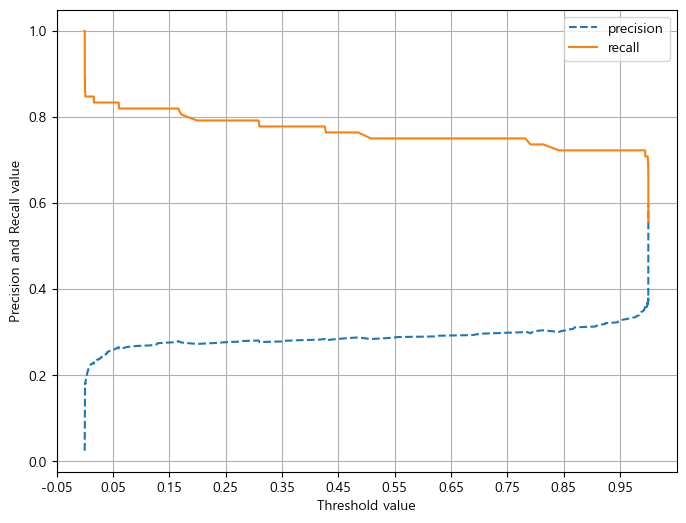

In [915]:
precision_recall_curve_plot(sc_test_y , pred_prob)

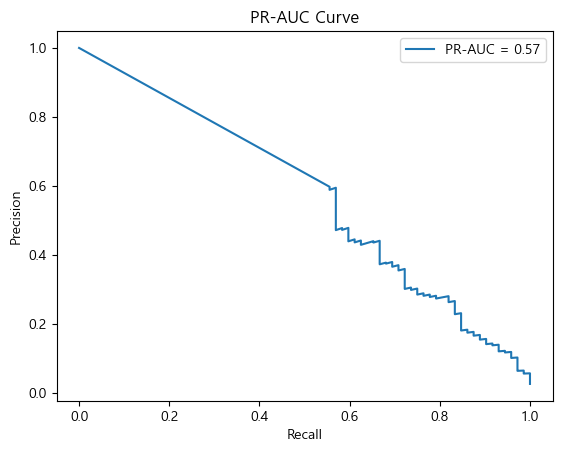

0.5701125151588287

In [899]:
plot_pr_auc_curve(sc_test_y,pred_prob)
get_pr_auc_score(sc_test_y,pred_prob)

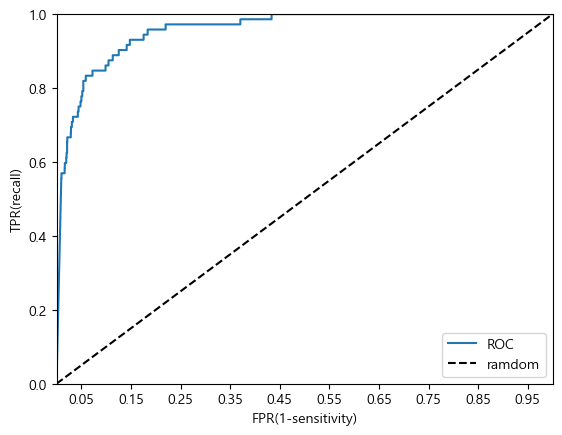

auc 값: 0.9576


In [900]:
## roc 커브 auc 값
roc_curve_plot(sc_test_y,pred_prob)
auc_score = roc_auc_score(sc_test_y,pred_prob)
print(f'auc 값: {np.round(auc_score,4)}')

## RandomForest

In [855]:
rf=RandomForestClassifier(random_state=1,n_jobs=-1,)
param = {
    'class_weight' :[None,'balanced'],
    'n_estimators': [50, 100],
    'max_depth': [15,20,25,30 ],
    'min_samples_split': [ 5,7, 10],
    'min_samples_leaf': [1, 2],
    'max_features': ['auto', 'sqrt']
}
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=1)
grid_rf = GridSearchCV(rf,n_jobs=-1,scoring='f1',cv=cv,param_grid=param,refit=True)
grid_rf.fit(sc_train_x,sc_train_y)

scores_df = pd.DataFrame(grid_rf.cv_results_)
scores_df[scores_df['rank_test_score']==1]

c:\Users\msi\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_class_weight,param_max_depth,param_max_features,param_min_samples_leaf,param_min_samples_split,param_n_estimators,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
50,1.085378,0.171327,0.294379,0.127474,None,25,auto,1,7,50,"{'class_weight': None, 'max_depth': 25, 'max_f...",0.510638,0.588235,0.561404,0.468085,0.6,0.545672,0.049513,1
62,1.049673,0.147686,0.556248,0.285062,None,25,sqrt,1,7,50,"{'class_weight': None, 'max_depth': 25, 'max_f...",0.510638,0.588235,0.561404,0.468085,0.6,0.545672,0.049513,1
74,1.305766,0.117607,0.438976,0.331431,None,30,auto,1,7,50,"{'class_weight': None, 'max_depth': 30, 'max_f...",0.510638,0.588235,0.561404,0.468085,0.6,0.545672,0.049513,1
86,1.199665,0.249463,0.274831,0.214154,None,30,sqrt,1,7,50,"{'class_weight': None, 'max_depth': 30, 'max_f...",0.510638,0.588235,0.561404,0.468085,0.6,0.545672,0.049513,1


In [967]:
print(grid_rf.best_params_)
pred = grid_rf.predict(sc_test_x)
pred_prob = grid_rf.predict_proba(sc_test_x)[:,1].reshape(-1,1)
eval(pred=pred,test=sc_test_y)

{'class_weight': None, 'max_depth': 25, 'max_features': 'auto', 'min_samples_leaf': 1, 'min_samples_split': 7, 'n_estimators': 50}
##############
 [[2807    7]
 [  27   45]] ############
 acc_score: 0.9882189882189882
 f1_score: 0.7258064516129031 
 precision: 0.8653846153846154 
 recall: 0.625


In [968]:
get_eval_by_threshold(sc_test_y,pred_prob,[0.42])

임곗값: 0.42
##############
 [[2793   21]
 [  22   50]] ############
 acc_score: 0.9851004851004851
 f1_score: 0.6993006993006993 
 precision: 0.704225352112676 
 recall: 0.6944444444444444


Text(51.722222222222214, 0.5, 'Actual')

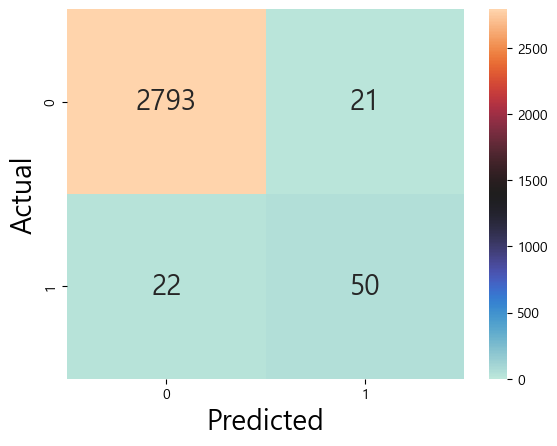

In [969]:
binarizer = Binarizer(threshold=0.42).fit(pred_prob) 
custom_rf = binarizer.transform(pred_prob)
cm = confusion_matrix(test_y, custom_rf)
sns.heatmap(cm, annot=True, annot_kws={"size": 20}, cmap="icefire", fmt='g',vmin=0)
plt.xlabel('Predicted', fontsize=20)
plt.ylabel('Actual', fontsize=20)

c:\Users\msi\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


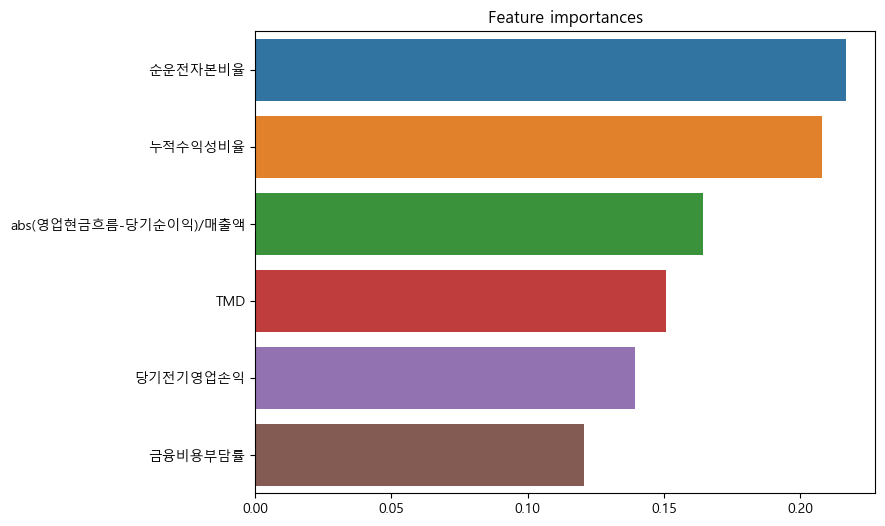

In [945]:
best_rf =RandomForestClassifier(random_state=1,class_weight=None, max_depth=25, max_features ='auto', min_samples_leaf= 1, min_samples_split= 7, n_estimators= 50)
best_rf.fit(sc_train_x,sc_train_y)
ftr_importances_values = best_rf.feature_importances_
ftr_importances = pd.Series(ftr_importances_values,index=grid_rf.feature_names_in_)
ftr_top = ftr_importances.sort_values(ascending=False)[:]

plt.rcParams['axes.unicode_minus'] = False
plt.rcParams["font.family"] = "Malgun Gothic"
plt.figure(figsize=(8,6))
plt.title('Feature importances')
sns.barplot(x=ftr_top , y = ftr_top.index)
plt.show()

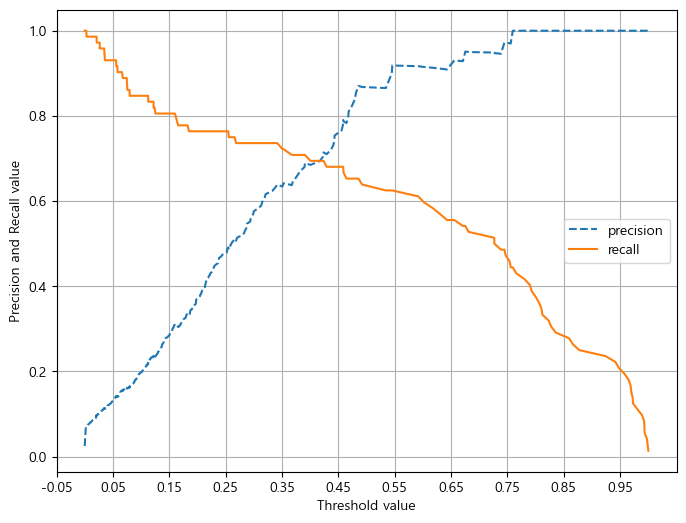

In [946]:
precision_recall_curve_plot(sc_test_y,pred_prob)

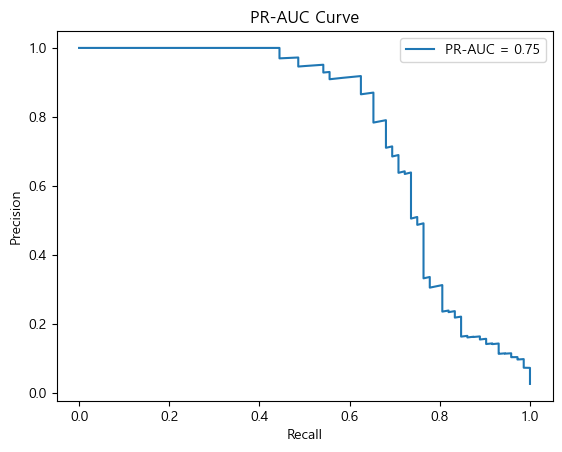

0.7534409056191793

In [947]:
plot_pr_auc_curve(test_y,pred_prob)
get_pr_auc_score(test_y,pred_prob)

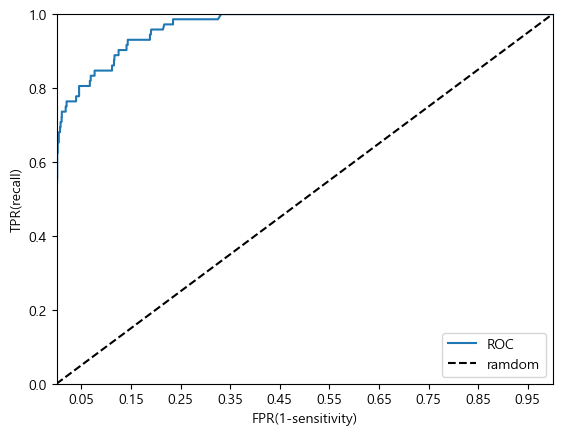

auc 값: 0.9673


In [948]:
## roc 커브 auc 값
roc_curve_plot(test_y,pred_prob)
auc_score = roc_auc_score(test_y,pred_prob)
print(f'auc 값: {np.round(auc_score,4)}')

----------------------------------------------------------
### xgboost

In [949]:
xgb = XGBClassifier(random_state=1, n_jobs=-1)
param = {
    'class_weight': ['balanced_subsample', 'balanced'],
    'n_estimators': [50,100],
    'max_depth': [ 10,15,20,25],
    'min_child_weight': [1, 3],
    'subsample': [0.7, 0.9],
    'colsample_bytree': [0.7, 0.8, 0.9],
    'learning_rate': [0.1, 0.01, 0.001],
    'gamma': [0]
}
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=1)
grid_xgb = GridSearchCV(xgb, n_jobs=-1, scoring='f1', cv=cv, param_grid=param, refit=True)
grid_xgb.fit(train_x, train_y)

scores_df = pd.DataFrame(grid_xgb.cv_results_)
print(scores_df.iloc[:, 4:])


[19:57:00] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-08de971ced8a8cdc6-1/xgboost/xgboost-ci-windows/src/learner.cc:767: 
Parameters: { "class_weight" } are not used.

     param_class_weight param_colsample_bytree param_gamma  \
0    balanced_subsample                    0.7           0   
1    balanced_subsample                    0.7           0   
2    balanced_subsample                    0.7           0   
3    balanced_subsample                    0.7           0   
4    balanced_subsample                    0.7           0   
..                  ...                    ...         ...   
571            balanced                    0.9           0   
572            balanced                    0.9           0   
573            balanced                    0.9           0   
574            balanced                    0.9           0   
575            balanced                    0.9           0   

    param_learning_rate param_max_depth param_min_chi

In [970]:
print(grid_xgb.best_params_)
pred = grid_xgb.predict(test_x)
pred_prob = grid_xgb.predict_proba(test_x)[:,1].reshape(-1,1)
eval(pred=pred,test=test_y)

{'class_weight': 'balanced_subsample', 'colsample_bytree': 0.9, 'gamma': 0, 'learning_rate': 0.1, 'max_depth': 10, 'min_child_weight': 1, 'n_estimators': 50, 'subsample': 0.9}
##############
 [[2803   11]
 [  28   44]] ############
 acc_score: 0.9864864864864865
 f1_score: 0.6929133858267716 
 precision: 0.8 
 recall: 0.6111111111111112


In [971]:
get_eval_by_threshold(sc_test_y,pred_prob,[0.39])

임곗값: 0.39
##############
 [[2793   21]
 [  24   48]] ############
 acc_score: 0.9844074844074844
 f1_score: 0.6808510638297872 
 precision: 0.6956521739130435 
 recall: 0.6666666666666666


Text(51.722222222222214, 0.5, 'Actual')

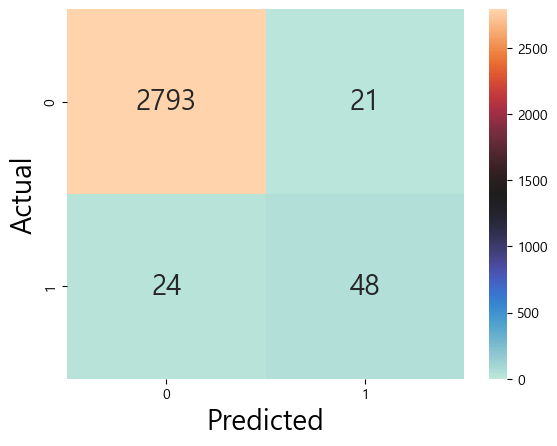

In [972]:
binarizer = Binarizer(threshold=0.39).fit(pred_prob) 
custom_rf = binarizer.transform(pred_prob)
cm = confusion_matrix(test_y, custom_rf)
sns.heatmap(cm, annot=True, annot_kws={"size": 20}, cmap="icefire", fmt='g',vmin=0)
plt.xlabel('Predicted', fontsize=20)
plt.ylabel('Actual', fontsize=20)

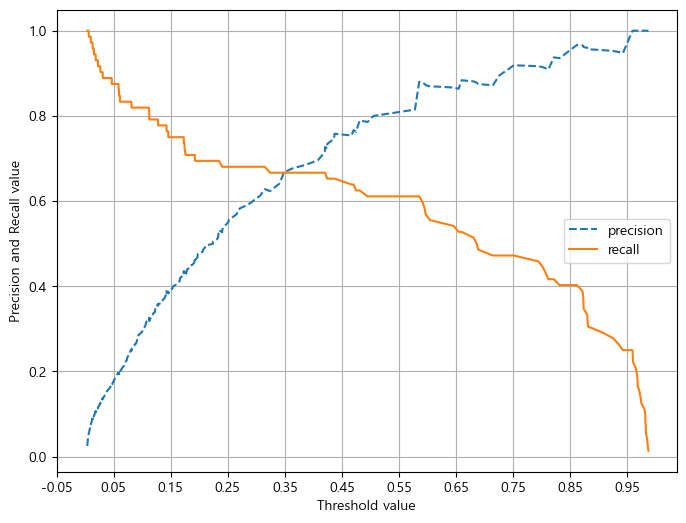

In [973]:
precision_recall_curve_plot(test_y,pred_prob)

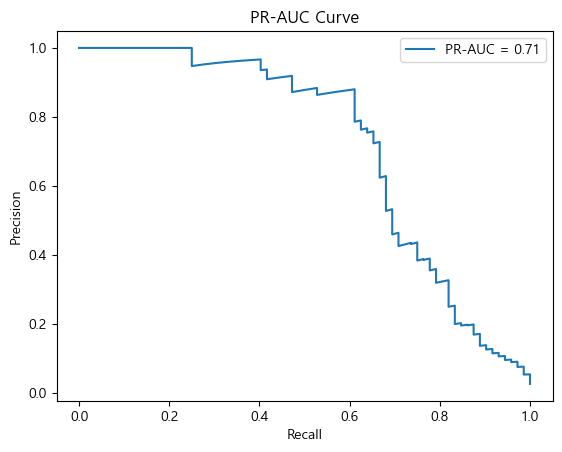

0.71389707187035

In [974]:
plot_pr_auc_curve(test_y,pred_prob)
get_pr_auc_score(test_y,pred_prob)

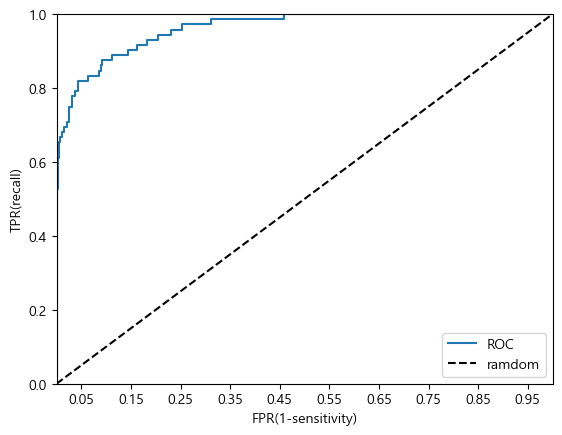

auc 값: 0.9619


In [975]:
## roc 커브 auc 값
roc_curve_plot(test_y,pred_prob)
auc_score = roc_auc_score(test_y,pred_prob)
print(f'auc 값: {np.round(auc_score,4)}')